In [1]:
'''
python /home/hsher/projects/oligoCLIP/scripts/analyze_betabinom_mixture_most_enriched.py \
    /home/hsher/scratch/oligo_PE_iter4/internal_output/DMN \
    Rep2.PRPF8 \
    /home/hsher/scratch/oligo_PE_iter4/internal_output/counts/genome/bgtables/internal/iter4.PRPF8.tsv.gz \
    /projects/ps-yeolab4/software/skipper/1.0.0/bin/skipper/annotations/gencode.v38.annotation.k562_totalrna.gt1.tiled_partition.features.tsv.gz

python /home/hsher/projects/oligoCLIP/scripts/analyze_betabinom_mixture_most_enriched.py \
    /home/hsher/scratch/oligo_PE_iter4/internal_output/DMN \
    Rep2.FXR2 \
    /home/hsher/scratch/oligo_PE_iter4/internal_output/counts/genome/bgtables/internal/iter4.FXR2.tsv.gz \
    /projects/ps-yeolab4/software/skipper/1.0.0/bin/skipper/annotations/gencode.v38.annotation.k562_totalrna.gt1.tiled_partition.features.tsv.gz

python /home/hsher/projects/oligoCLIP/scripts/analyze_betabinom_mixture_most_enriched.py \
    /home/hsher/scratch/ABC_2rep/beta-mixture_CC \
    K562_rep4.PRPF8 \
    /home/hsher/scratch/ABC_2rep/counts_CC/genome/bgtables/internal/K562.PRPF8.tsv.gz \
    /projects/ps-yeolab4/software/skipper/1.0.0/bin/skipper/annotations/gencode.v38.annotation.k562_totalrna.gt1.tiled_partition.features.tsv.gz
'''
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import stats

from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import betabinom

from plot_params import *
from pybedtools import BedTool

In [2]:

window_bed = BedTool('/projects/ps-yeolab4/software/skipper/1.0.0/bin/skipper/annotations/gencode.v38.annotation.k562_totalrna.gt1.tiled_partition.features.tsv.gz')
window_df = pd.read_csv(window_bed.fn, sep = '\t')

pum_motif = pd.read_csv('/home/hsher/scratch/k562_window_pum2.homer.motif', sep = '\t')
pum_motif = pum_motif.loc[pum_motif['Motif Name']=='1-TGTATATA']
pum_motif['windowstrand']=pum_motif['PositionID'].map(window_df.set_index('name')['strand'])
pum_motif.dropna(inplace = True)
pum_motif = pum_motif.loc[pum_motif['Strand']==pum_motif['windowstrand']]

rbfox2_motif = pd.read_csv('/home/hsher/scratch/k562_window_rbfox2.homer.motif', sep = '\t')
rbfox2_motif = rbfox2_motif.loc[rbfox2_motif['Motif Name']=='1-TGCATG']
rbfox2_motif['windowstrand']=rbfox2_motif['PositionID'].map(window_df.set_index('name')['strand'])
rbfox2_motif.dropna(inplace = True)
rbfox2_motif = rbfox2_motif.loc[rbfox2_motif['Strand']==rbfox2_motif['windowstrand']]


In [3]:
# eCLIP binding sites
ground_truth_skipper = pd.read_csv('ABC_K562.skipper_reproducible_window.csv',
                          index_col = 0)
ground_truth_skipper.rename({'DDX3X':'DDX3'}, axis = 1, inplace = True)
ground_truth_skipper.sum().sort_values()

EIF3G         213
ZC3H11A      4722
PUM2         7147
RBFOX2      12206
DDX3        12334
LIN28B      26668
IGF2BP2     28834
SF3B4       44025
FAM120A     50622
PRPF8      102243
dtype: int64

In [4]:
basedir=Path('/home/hsher/scratch/ABC_singleplex_K562_RBFOX2/')

In [5]:
def is_goldstandard(row):
    return ('UTR3' in row['feature_types'] or 'CDS_STOP' in row['feature_types']) and (
        row['gene_name'].startswith('H1') or row['gene_name'].startswith('H2') or
        row['gene_name'].startswith('H3') or row['gene_name'].startswith('H4'))
        

In [6]:
# find all files
beta_external = list(basedir.glob('beta-mixture_external/*/*window_score.tsv'))

In [7]:
cdict = dict(zip(['oligoCLIP_ctrlSpike_rep1', 'oligoCLIP_ctrlSpike_rep2',
       'oligoCLIP_ctrlBead_rep1', 'oligoCLIP_ctrlBead_rep2',
                  'oligoCLIP_IgG_rep2','oligoCLIP_IgG_rep1',
       'eCLIP_SLBP_SMInput', 'ABC_K562_summed'
       , 'K562_totalRNAseq'],
        
                 ['tomato', 'red',
                  'gold', 'orange', 
                  'seagreen', 'limegreen',
                  'grey', 
                  'orchid', 
                  'royalblue']
                ))

(1307, 25) oligoCLIP_ctrlBead_rep1 K562_RBFOX2_rep2
(1481, 25) oligoCLIP_ctrlBead_rep1 K562_RBFOX2_rep1
(1477, 25) oligoCLIP_ctrlBead_rep2 K562_RBFOX2_rep1
(1300, 25) oligoCLIP_ctrlBead_rep2 K562_RBFOX2_rep2
(1581, 25) oligoCLIP_IgG_rep1 K562_RBFOX2_rep2
(1728, 25) oligoCLIP_IgG_rep1 K562_RBFOX2_rep1
(8175, 32) K562_totalRNAseq K562_RBFOX2_rep2
(8355, 32) K562_totalRNAseq K562_RBFOX2_rep1
(146111, 32) ABC_K562_summed K562_RBFOX2_rep1
(145081, 32) ABC_K562_summed K562_RBFOX2_rep2
(5323, 30) oligoCLIP_ctrlSpike_rep1 K562_RBFOX2_rep1
(5105, 30) oligoCLIP_ctrlSpike_rep1 K562_RBFOX2_rep2
(1986, 25) oligoCLIP_IgG_rep2 K562_RBFOX2_rep1
(1849, 25) oligoCLIP_IgG_rep2 K562_RBFOX2_rep2
(5369, 32) eCLIP_SLBP_SMInput K562_RBFOX2_rep1
(5098, 30) eCLIP_SLBP_SMInput K562_RBFOX2_rep2
(10964, 30) oligoCLIP_ctrlSpike_rep2 K562_RBFOX2_rep1
(10630, 30) oligoCLIP_ctrlSpike_rep2 K562_RBFOX2_rep2


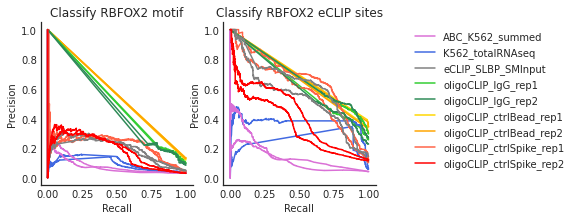

In [8]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from collections import OrderedDict
stat = []
stat_eclip = []
cnts = []
cnts_eclip = []

f, ax = plt.subplots(1,2, figsize = (6,3))
for file in beta_external:
    rep = file.name.split('.')[0]
    ctrl = file.parent.name
    
    df = pd.read_csv(file, sep = '\t')
    print(df.shape, ctrl, rep)
    df['is_motif']=df['name'].isin(rbfox2_motif['PositionID'])
    df['is_eclip']=df['name'].isin(ground_truth_skipper.loc[ground_truth_skipper['RBFOX2']].index.tolist())
    
    try:
        df['composite_score']=(-np.log(df['pvalue']+1e-5)).fillna(0)+df['logLR'].fillna(0)
    except:
        try:
            df['composite_score']=(-np.log(df['pvalue']+1e-5)).fillna(0)
        except:
            df['composite_score'] = df['logLR'].fillna(-100)
    
    df['composite_score'] = df['composite_score'].replace(-np.inf, -100)
    
    # both
    precision, recall, thresholds = precision_recall_curve(df['is_motif'], 
                                                        df['composite_score'])
    
    auprc = auc(recall, precision)
    ax[0].plot(recall, precision, label = f'{ctrl}',color = cdict[ctrl])
    ax[0].set_title('Classify RBFOX2 motif')
    ax[0].set_xlabel('Recall')
    ax[0].set_ylabel('Precision')
    stat.append([rep, ctrl, auprc])
    
    # classify eCLIP binding sites
    precision, recall, thresholds = precision_recall_curve(df['is_eclip'], 
                                                        df['composite_score'])
    
    auprc = auc(recall, precision)
    ax[1].plot(recall, precision, label = f'{ctrl}',color = cdict[ctrl])
    stat_eclip.append([rep, ctrl, auprc])
    ax[1].set_title('Classify RBFOX2 eCLIP sites')
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    
#     # logLR
#     try:
#         precision, recall, thresholds = precision_recall_curve(df.loc[~df['logLR'].isnull(), 'is_motif'], 
#                                                             df.loc[~df['logLR'].isnull(), 'logLR'])

#         auprc = auc(recall, precision)
#         ax[1].plot(recall, precision, label = f'{ctrl}(AUPRC={auprc:.2f})', color = cdict[ctrl])
#     except:
#         pass
    
#     # pval
#     try:
#         precision, recall, thresholds = precision_recall_curve(df.loc[~df['pvalue'].isnull(), 'is_motif'], 
#                                                             1-df.loc[~df['pvalue'].isnull(), 'pvalue'])

#         auprc = auc(recall, precision)
#         ax[2].plot(recall, precision, label = f'{ctrl}(AUPRC={auprc:.2f})',color = cdict[ctrl])
#     except:
#         pass
    
    pivot = df.groupby(by = ['enriched', 'is_motif']).count()['name']
    pivot.name = ctrl+'.'+rep
    cnts.append(pivot)
    
    pivot = df.groupby(by = ['enriched', 'is_eclip']).count()['name']
    pivot.name = ctrl+'.'+rep
    cnts_eclip.append(pivot)
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(sorted(zip(labels, handles), key=lambda x: x[0]))
ax[0].legend(by_label.values(), by_label.keys(), bbox_to_anchor = (3.5, 1))



sns.despine()
cnts=pd.concat(cnts,axis = 1).fillna(0)
cnts_eclip=pd.concat(cnts_eclip,axis = 1).fillna(0)
stat = pd.DataFrame(stat, columns = ['rep', 'ctrl', 'AUPRC'])
stat_eclip = pd.DataFrame(stat_eclip, columns = ['rep', 'ctrl', 'AUPRC'])

plt.savefig(figdir/'AUPRC_beta_RBFOX2singleplex.pdf')

In [9]:
def cnt_to_f1(cnts):
    precision_at_cutoff = (cnts.loc[True, True]/(cnts.loc[True, True]+cnts.loc[True, False]))
    recall_at_cutoff = (cnts.loc[True, True]/(cnts.loc[True, True]+cnts.loc[False, True]))
    id_ = pd.Series(precision_at_cutoff.index).str.split('.', expand = True)
    id_.index = precision_at_cutoff.index
    pr_cutoff = pd.concat([precision_at_cutoff, recall_at_cutoff, id_], axis = 1)
    pr_cutoff.columns = ['Precision', 'Recall','ctrl', 'lib']
    pr_cutoff['F1'] = 2 * (precision_at_cutoff * recall_at_cutoff) / (precision_at_cutoff + recall_at_cutoff)
    pr_cutoff['ctrl_type']=pr_cutoff['ctrl'].str.split('_rep', expand = True)[0]
    return pr_cutoff

In [10]:
pr_cutoff = cnt_to_f1(cnts)
pr_cutoff_eclip = cnt_to_f1(cnts_eclip)

In [ ]:
perc_histone

,0,type
oligoCLIP_ctrlBead_rep1.K562_RBFOX2_rep2,0.348197,oligoCLIP_ctrlBead
oligoCLIP_ctrlBead_rep1.K562_RBFOX2_rep1,0.392623,oligoCLIP_ctrlBead
oligoCLIP_ctrlBead_rep2.K562_RBFOX2_rep1,0.377255,oligoCLIP_ctrlBead
oligoCLIP_ctrlBead_rep2.K562_RBFOX2_rep2,0.333935,oligoCLIP_ctrlBead
oligoCLIP_IgG_rep1.K562_RBFOX2_rep2,0.464696,oligoCLIP_IgG
oligoCLIP_IgG_rep1.K562_RBFOX2_rep1,0.528833,oligoCLIP_IgG
K562_totalRNAseq.K562_RBFOX2_rep2,0.138306,K562_totalRNAseq
K562_totalRNAseq.K562_RBFOX2_rep1,0.240513,K562_totalRNAseq
ABC_K562_summed.K562_RBFOX2_rep1,0.444068,ABC_K562_summed
ABC_K562_summed.K562_RBFOX2_rep2,0.319048,ABC_K562_summed


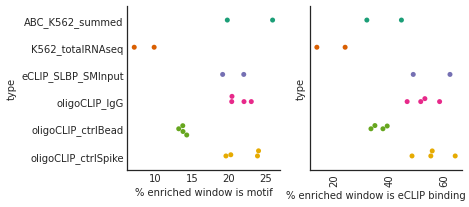

In [72]:

f, ax = plt.subplots(1,2,figsize = (6,3), sharey = True)


perc_histone = (cnts.loc[True, True]/(cnts.loc[True, True]+cnts.loc[True, False])).to_frame()*100
perc_histone['type'] = [i.split('_rep')[0] for i in pd.Series(perc_histone.index).str.split('.', expand = True)[0].tolist()]
sns.swarmplot(data=perc_histone.sort_index(), x = 0, y = 'type', ax = ax[0])

ax[0].set_xlabel('% enriched window is motif')
sns.despine()



perc_histone = (cnts_eclip.loc[True, True]/(cnts_eclip.loc[True, True]+cnts_eclip.loc[True, False])).to_frame()*100
perc_histone['type'] = [i.split('_rep')[0] for i in pd.Series(perc_histone.index).str.split('.', expand = True)[0].tolist()]

sns.swarmplot(data=perc_histone.sort_index(), x = 0, y = 'type', ax = ax[1])
ax[1].set_xlabel('% enriched window is eCLIP binding site')
sns.despine()
plt.xticks(rotation = 90)
plt.savefig(figdir/'RBFOX2_singleplex_perc_eclip.pdf')

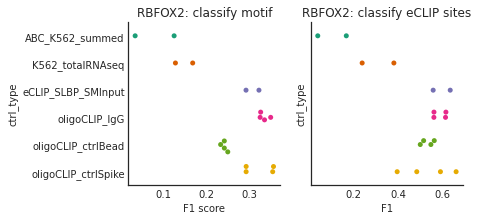

In [85]:
f, ax = plt.subplots(1,2, figsize = (6,3), sharey = True)
sns.swarmplot(data = pr_cutoff.sort_index(), y = 'ctrl_type', x = 'F1',  ax=ax[0])
sns.swarmplot(data = pr_cutoff_eclip.sort_index(), y = 'ctrl_type', x = 'F1',  ax=ax[1])
ax[0].set_xlabel('F1 score')
ax[0].set_title('RBFOX2: classify motif')
ax[1].set_title('RBFOX2: classify eCLIP sites')
sns.despine()
plt.savefig(figdir/'F1_beta_RBFOX2singleplex.pdf')

In [90]:
for i in pr_cutoff_eclip['ctrl_type'].unique():
    print(i)
    print(ttest_ind(pr_cutoff_eclip.loc[pr_cutoff_eclip['ctrl_type']==i, 'F1'],
         pr_cutoff_eclip.loc[pr_cutoff_eclip['ctrl_type']=='eCLIP_SLBP_SMInput', 'F1']
        ))

oligoCLIP_ctrlBead
Ttest_indResult(statistic=-2.031173720164339, pvalue=0.11206292304237762)
oligoCLIP_IgG
Ttest_indResult(statistic=-0.2567756470674596, pvalue=0.8100186149271583)
K562_totalRNAseq
Ttest_indResult(statistic=-3.536958072314143, pvalue=0.0714717491576053)
ABC_K562_summed
Ttest_indResult(statistic=-6.598217178869309, pvalue=0.022206995204035348)
oligoCLIP_ctrlSpike
Ttest_indResult(statistic=-0.6981674332786377, pvalue=0.5235304691660889)
eCLIP_SLBP_SMInput
Ttest_indResult(statistic=0.0, pvalue=1.0)


In [87]:
from scipy.stats import ttest_ind
ttest_ind(pr_cutoff.loc[pr_cutoff['ctrl_type']=='K562_totalRNAseq', 'F1'],
         pr_cutoff.loc[pr_cutoff['ctrl_type']=='eCLIP_SLBP_SMInput', 'F1']
        )

Ttest_indResult(statistic=-6.343876946791973, pvalue=0.023958573259087027)

In [80]:
from scipy.stats import ttest_ind
ttest_ind(pr_cutoff.loc[pr_cutoff['ctrl_type']=='K562_totalRNAseq', 'F1'],
         pr_cutoff.loc[pr_cutoff['ctrl_type']=='eCLIP_SLBP_SMInput', 'F1']
        )

Ttest_indResult(statistic=-6.343876946791973, pvalue=0.023958573259087027)

In [86]:
from scipy.stats import ttest_ind
ttest_ind(pr_cutoff.loc[pr_cutoff['ctrl_type']=='oligoCLIP_IgG', 'F1'],
         pr_cutoff.loc[pr_cutoff['ctrl_type']=='eCLIP_SLBP_SMInput', 'F1']
        )


Ttest_indResult(statistic=2.1383524611773748, pvalue=0.09927139592035479)

In [83]:
from scipy.stats import ttest_ind
ttest_ind(pr_cutoff.loc[pr_cutoff['ctrl_type']=='oligoCLIP_ctrlBead', 'F1'],
         pr_cutoff.loc[pr_cutoff['ctrl_type']=='eCLIP_SLBP_SMInput', 'F1']
        )

Ttest_indResult(statistic=-6.238753049031903, pvalue=0.0033636222649978654)

In [84]:
from scipy.stats import ttest_ind
ttest_ind(pr_cutoff.loc[pr_cutoff['ctrl_type']=='oligoCLIP_ctrlSpike', 'F1'],
         pr_cutoff.loc[pr_cutoff['ctrl_type']=='eCLIP_SLBP_SMInput', 'F1']
        )

Ttest_indResult(statistic=0.5790037104568645, pvalue=0.5936275396302596)

In [14]:
skipper_external = list(basedir.glob('skipper_external/*/tested_windows/*.tested_windows.tsv.gz'))
window_df = pd.read_csv('/projects/ps-yeolab4/software/skipper/1.0.0/bin/skipper/annotations/gencode.v38.annotation.k562_totalrna.gt1.tiled_partition.features.tsv.gz', sep = '\t')

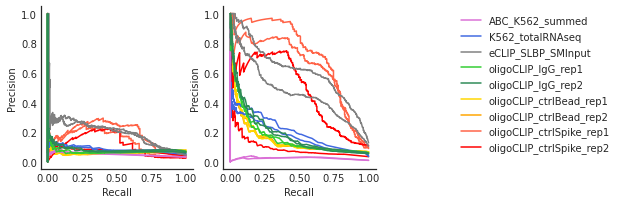

In [15]:
stat_skipper=[]
stat_skipper_eclip=[]
skipper_cnts = []
skipper_cnts_eclip = []


f, ax = plt.subplots(1,2,figsize = (6,3))
for f in skipper_external:
    rep = f.name.split('.')[0]
    ctrl = f.parent.parent.name
    df = pd.read_csv(f, sep = '\t')
    df['feature_types']=df['name'].map(window_df.set_index('name')['feature_types'])
    df['gene_name']=df['name'].map(window_df.set_index('name')['gene_name'])      
    iteration = str(f).split('/')[4]
    background = 'CC' if 'CC' in str(f) else 'IgG'
    exp = f.name.split('.')[0]
    if df.shape[0]>0:
        
        
        df['pvalue'].fillna(1)
        df['is_motif']=df['name'].isin(rbfox2_motif['PositionID'])
        df['is_eclip']=df['name'].isin(ground_truth_skipper.loc[ground_truth_skipper['RBFOX2']].index.tolist())
        
        precision, recall, thresholds = precision_recall_curve(df['is_motif'], 
                                                        -df['pvalue'])
        auprc = auc(recall, precision)
        ax[0].plot(recall, precision, label = f'{ctrl}', color = cdict[ctrl])
        ax[0].set_xlabel('Recall')
        ax[0].set_ylabel('Precision')
        stat_skipper.append([rep, ctrl, auprc])
        
        precision, recall, thresholds = precision_recall_curve(df['is_eclip'], 
                                                        -df['pvalue'])
        auprc = auc(recall, precision)
        ax[1].plot(recall, precision, label = f'{ctrl}', color = cdict[ctrl])
        ax[1].set_xlabel('Recall')
        ax[1].set_ylabel('Precision')
        stat_skipper_eclip.append([rep, ctrl, auprc])
        
        
        
        
        df['enriched']=df['qvalue'].le(0.2)
        pivot = df.groupby(by = ['enriched', 'is_motif']).count()['name']
        pivot.name = ctrl+'.'+rep
        skipper_cnts.append(pivot)
        
        pivot = df.groupby(by = ['enriched', 'is_eclip']).count()['name']
        pivot.name = ctrl+'.'+rep
        skipper_cnts_eclip.append(pivot)
        

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(sorted(zip(labels, handles), key=lambda x: x[0]))
ax[1].legend(by_label.values(), by_label.keys(), bbox_to_anchor = (1.5, 1))
sns.despine()


stat_skipper = pd.DataFrame(stat_skipper, columns = ['rep', 'ctrl', 'AUPRC'])
skipper_cnts=pd.concat(skipper_cnts,axis = 1).fillna(0)
stat_skipper_eclip = pd.DataFrame(stat_skipper_eclip, columns = ['rep', 'ctrl', 'AUPRC'])
skipper_cnts_eclip=pd.concat(skipper_cnts_eclip,axis = 1).fillna(0)
plt.savefig(figdir/'AUPRC_skipper_RBFOX2singleplex.pdf')

In [16]:
pr_cutoff_skipper = cnt_to_f1(skipper_cnts).fillna(0)
pr_cutoff_skipper_eclip = cnt_to_f1(skipper_cnts_eclip).fillna(0)

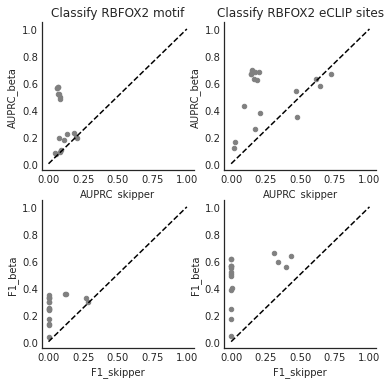

In [17]:
f, ax = plt.subplots(2,2, figsize = (6,6))
data = stat_skipper.merge(stat, left_on = ['rep', 'ctrl'], right_on = ['rep', 'ctrl'],
                   suffixes = ('_skipper', '_beta'))
data.plot.scatter(x='AUPRC_skipper', y = 'AUPRC_beta', ax = ax[0,0], color = 'grey')
ax[0,0].set_title('Classify RBFOX2 motif')

data = stat_skipper_eclip.merge(stat_eclip, left_on = ['rep', 'ctrl'], right_on = ['rep', 'ctrl'],
                   suffixes = ('_skipper', '_beta'))
data.plot.scatter(x='AUPRC_skipper', y = 'AUPRC_beta', ax = ax[0,1], color = 'grey')
ax[0,1].set_title('Classify RBFOX2 eCLIP sites')

pr_cutoff_skipper.merge(pr_cutoff, left_index = True, right_index = True, suffixes = ('_skipper', '_beta')
                       ).plot.scatter(x='F1_skipper', y = 'F1_beta', ax = ax[1,0], color = 'grey')

pr_cutoff_skipper_eclip.merge(pr_cutoff_eclip, left_index = True, right_index = True, suffixes = ('_skipper', '_beta')
                       ).plot.scatter(x='F1_skipper', y = 'F1_beta', ax = ax[1,1], color = 'grey')

_ = [a.plot([0,1], [0,1],  color = 'black',linestyle='dashed') for a in ax.flatten()]
sns.despine()
plt.savefig(figdir/'F1compare_RBFOX2singleplex.pdf')

In [18]:
skipper_cnts.loc[True, True].sort_index()

ABC_K562_summed.K562_RBFOX2_rep1               0.0
ABC_K562_summed.K562_RBFOX2_rep2               0.0
K562_totalRNAseq.K562_RBFOX2_rep1              0.0
K562_totalRNAseq.K562_RBFOX2_rep2              0.0
eCLIP_SLBP_SMInput.K562_RBFOX2_rep1           91.0
eCLIP_SLBP_SMInput.K562_RBFOX2_rep2          151.0
oligoCLIP_IgG_rep1.K562_RBFOX2_rep1            0.0
oligoCLIP_IgG_rep1.K562_RBFOX2_rep2            0.0
oligoCLIP_IgG_rep2.K562_RBFOX2_rep1            0.0
oligoCLIP_IgG_rep2.K562_RBFOX2_rep2            0.0
oligoCLIP_ctrlBead_rep1.K562_RBFOX2_rep1       0.0
oligoCLIP_ctrlBead_rep1.K562_RBFOX2_rep2       0.0
oligoCLIP_ctrlBead_rep2.K562_RBFOX2_rep1       0.0
oligoCLIP_ctrlBead_rep2.K562_RBFOX2_rep2       0.0
oligoCLIP_ctrlSpike_rep1.K562_RBFOX2_rep1      7.0
oligoCLIP_ctrlSpike_rep1.K562_RBFOX2_rep2     12.0
oligoCLIP_ctrlSpike_rep2.K562_RBFOX2_rep1      0.0
oligoCLIP_ctrlSpike_rep2.K562_RBFOX2_rep2      0.0
Name: (True, True), dtype: float64